In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import missingno as msno
import warnings
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import SGDClassifier
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [10]:
data = pd.read_csv('data/ads_train.csv') 
data.dtypes.value_counts()

int64      10
float64     5
dtype: int64

In [11]:
new_col = ['isbuyer', 'visit_freq', 'buy_interval', 'sv_interval',
       'expected_time_buy', 'expected_time_visit', 'last_buy', 'last_visit',
       'multiple_buy', 'multiple_visit', 'uniq_urls', 'num_checkins', 'y_buy']
data = data[new_col]

In [12]:
col = data.select_dtypes(include=['int64','float64']).columns
col = col.drop('y_buy')

In [13]:
data_ml_df = data

In [15]:
sc = StandardScaler()
data_ml_df[col] = sc.fit_transform(data_ml_df[col])
data_ml_df.head()

,isbuyer,visit_freq,buy_interval,sv_interval,expected_time_buy,expected_time_visit,last_buy,last_visit,multiple_buy,multiple_visit,uniq_urls,num_checkins,y_buy
0,-0.21042,-0.28972,-0.05120,-0.33071,0.03645,0.31880,0.77344,0.77344,-0.07748,-0.61978,1.33040,1.09313,0
1,-0.21042,-0.28972,-0.05120,-0.33071,0.03645,0.31880,-1.09737,-1.09737,-0.07748,-0.61978,1.02365,-0.14369,0
2,-0.21042,0.04398,-0.05120,-0.30250,0.03645,-2.86235,0.67990,0.67990,-0.07748,1.61346,0.26486,-0.28128,0
3,-0.21042,-0.28972,-0.05120,-0.33071,0.03645,0.31880,-0.42388,-0.42388,-0.07748,-0.61978,-1.12358,-0.53549,0
4,-0.21042,0.37769,-0.05120,2.23494,0.03645,-0.75505,-0.01230,-0.01230,-0.07748,1.61346,0.21642,-0.33104,0


In [16]:
x_feature = list(data_ml_df.columns)
x_feature.remove('y_buy')
x_val = data_ml_df[x_feature]
y_val = data_ml_df['y_buy']


12

In [18]:
model = LogisticRegression()
rfe = RFE(model, 8)
rfe = rfe.fit(x_val, y_val)

In [19]:
col_filter = x_val.columns[rfe.support_]
col_filter

Index(['isbuyer', 'sv_interval', 'expected_time_visit', 'last_buy',
       'last_visit', 'multiple_buy', 'multiple_visit', 'uniq_urls'],
      dtype='object')

In [20]:
X = data_ml_df[col]
y = data_ml_df['y_buy']

n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('特征维数：', X.shape[1])

样本个数：38209; 正样本占99.55%; 负样本占0.45%
特征维数： 12


In [22]:
sm = SMOTE(random_state=42)
X_source, y_source = X, y
X, y = sm.fit_sample(X, y)
print('通过SMOTE方法平衡正负样本后')
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))

通过SMOTE方法平衡正负样本后
样本个数：76074; 正样本占50.00%; 负样本占50.00%


In [60]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
def different_thrsholds(X, y, thresholds, model):
    y_pred_proba = model.predict_proba(X)  #predict_prob 获得一个概率值

    plt.figure(figsize=(15,10))

    j = 1
    for i in thresholds:
        y_test_predictions_high_recall = y_pred_proba[:,1] > i#预测出来的概率值是否大于阈值 

        plt.subplot(3,3,j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y, y_test_predictions_high_recall)
        np.set_printoptions(precision=2)

        print("Recall metric in the testing dataset: ",(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

        # Plot non-normalized confusion matrix
        class_names = [0,1]
        plot_confusion_matrix(cnf_matrix
                              , classes=class_names)

### 模型训练

#### 逻辑回归

In [58]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) # random_state = 0 每次切分的数据都一样
# 构建参数组合
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

lr_grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = lr_grid_search.fit(X, y)

In [36]:
y_pred = lr_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))

Test set accuracy score: 0.85066
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     32433
           1       0.70      0.02      0.04      5776

   micro avg       0.85      0.85      0.85     38209
   macro avg       0.78      0.51      0.48     38209
weighted avg       0.83      0.85      0.79     38209



Recall metric in the testing dataset:  0.9709302325581395
Recall metric in the testing dataset:  0.9302325581395349
Recall metric in the testing dataset:  0.9186046511627907
Recall metric in the testing dataset:  0.8372093023255814
Recall metric in the testing dataset:  0.7034883720930233
Recall metric in the testing dataset:  0.6686046511627907
Recall metric in the testing dataset:  0.622093023255814
Recall metric in the testing dataset:  0.4476744186046512
Recall metric in the testing dataset:  0.28488372093023256


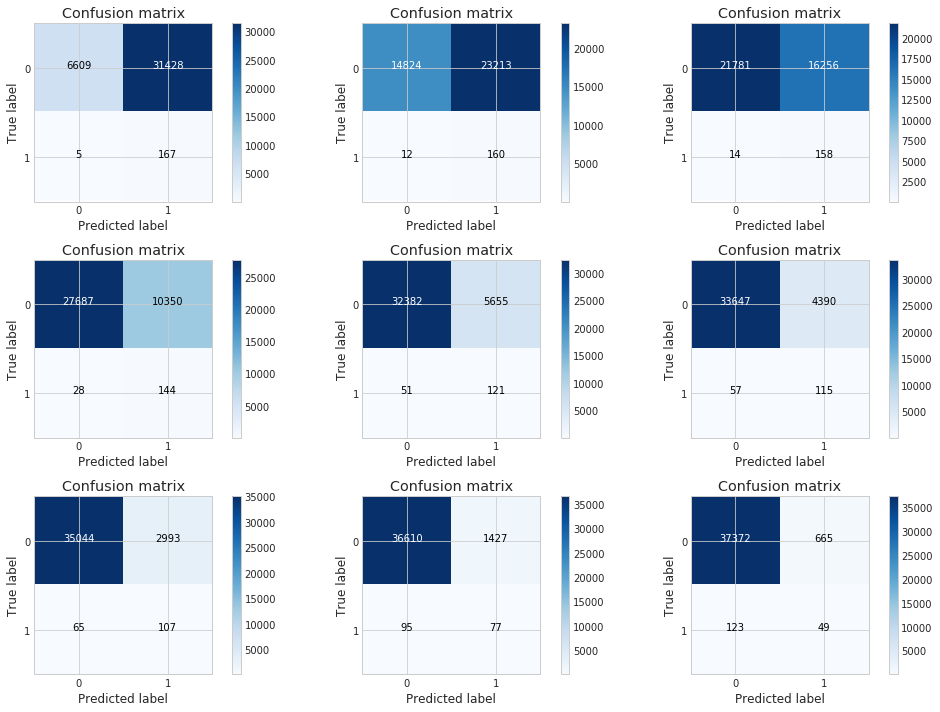

In [59]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=lr_grid_search)

#### SGDClassifier模型

In [ ]:
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'penalty': ['l2', 'l1', 'elasticnet'],
             'alpha ': [0.1, 0.01, 0.001, 0.0001],
             'max_iter':[5, 10, 20],
             'n_jobs':[-1],
             'learning_rate': ['constant', 'optimal', 'invscaling',
                              'adaptive']}
sgd_grid_search = GridSearchCV(SGDClassifier(),  param_grid, cv=10) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定5折
cl2 = sgd_grid_search.fit(X, y)

In [ ]:
y_pred = sgd_grid_search.predict(x_val)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_val, y_pred)))
print(classification_report(y_pred, y_val))
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
different_thrsholds(data_ml_df[col], data_ml_df['y_buy'], thresholds, model=sgd_grid_search)